**Feature Extraction and Selection:**
- This basic example shows how to use tsfresh to extract useful features from multiple timeseries and then use them to improve classification performance.

We use the robot execution failure dataset as an example

In [1]:
import matplotlib.pyplot as plt
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

**Load and Visualise the data:**
- The dataset documents 88 robot executions (each has a unique id between 1 and 88). For simplicity - we are only differentiating between successful and failed executions (y).
- For each execution, 15 force (F), and torque (T) samples are given, which were measured at regular time intervals for the spatial dimensions x, y, and z. Therefore, each row of the dataframe references a specific execution (id), a time index (index), and documents the respective measurements of 6 sensors (F_x, F_y, F_z, T_x, T_y, and T_z)

In [2]:
from tsfresh.examples import robot_execution_failures

robot_execution_failures.download_robot_execution_failures()
df, y = robot_execution_failures.load_robot_execution_failures()
df.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


For each execution - we have time ordered by these integers - and also the corresponding time series force and torque measurements. 

In [3]:
df[df['id'] == 1]['time'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [4]:
df[df['id'] == 2]['time'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

Let's draw some example executions:

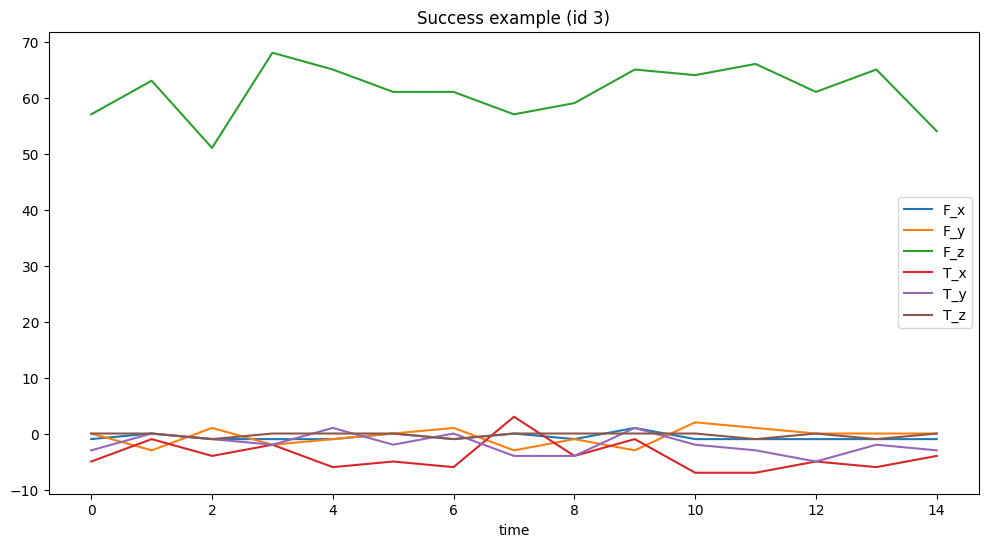

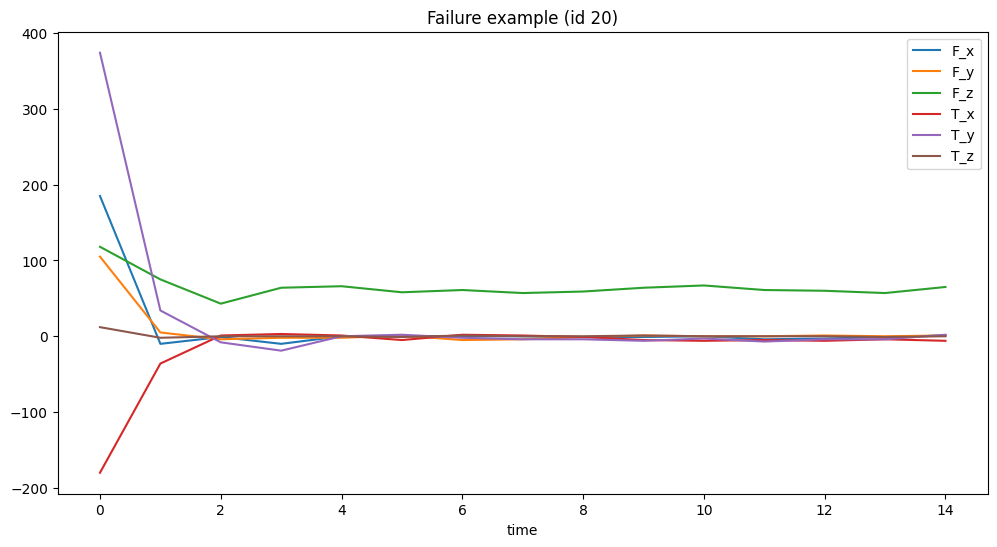

In [5]:
df[df.id == 3][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Success example (id 3)', figsize=(12, 6));
df[df.id == 20][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Failure example (id 20)', figsize=(12, 6));

**Extract Features:**
- We can use the data to extract time series features using tsfresh. We want to extract features for each time series, which means that for each robot execution (which is our id), and for each of the measured sensor values (F_* and T_*).
- Can think of this like this - tsfresh will result in a single row for each id, and will calculate the features for each columns - separately.
- Time column is our sorting column:

In [6]:
extraction_settings = ComprehensiveFCParameters()

X = extract_features(df, column_id = 'id', column_sort = 'time', 
                    default_fc_parameters = extraction_settings,
                    impute_function = impute)

Feature Extraction: 100%|██████████| 38/38 [00:20<00:00,  1.83it/s]


In [7]:
X.shape

(88, 4698)

X now contains, for each robot execution (=id), a single row, with all the features tsfresh calculated based on the measured time series values for this id

In [8]:
X.head()

,F_z__variance_larger_than_standard_deviation,F_z__has_duplicate_max,F_z__has_duplicate_min,F_z__has_duplicate,F_z__sum_values,F_z__abs_energy,F_z__mean_abs_change,F_z__mean_change,F_z__mean_second_derivative_central,F_z__median,F_z__mean,F_z__length,F_z__standard_deviation,F_z__variation_coefficient,F_z__variance,F_z__skewness,F_z__kurtosis,F_z__root_mean_square,F_z__absolute_sum_of_changes,F_z__longest_strike_below_mean,F_z__longest_strike_above_mean,F_z__count_above_mean,F_z__count_below_mean,F_z__last_location_of_maximum,F_z__first_location_of_maximum,F_z__last_location_of_minimum,F_z__first_location_of_minimum,F_z__percentage_of_reoccurring_values_to_all_values,F_z__percentage_of_reoccurring_datapoints_to_all_datapoints,F_z__sum_of_reoccurring_values,F_z__sum_of_reoccurring_data_points,F_z__ratio_value_number_to_time_series_length,F_z__sample_entropy,F_z__maximum,F_z__absolute_maximum,F_z__minimum,F_z__benford_correlation,F_z__time_reversal_asymmetry_statistic__lag_1,F_z__time_reversal_asymmetry_statistic__lag_2,F_z__time_reversal_asymmetry_statistic__lag_3,...,F_y__number_crossing_m__m_1,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_0,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_1,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_2,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_3,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_4,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_5,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_6,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_7,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_8,F_y__energy_ratio_by_chunks__num_segments_10__segment_focus_9,F_y__ratio_beyond_r_sigma__r_0.5,F_y__ratio_beyond_r_sigma__r_1,F_y__ratio_beyond_r_sigma__r_1.5,F_y__ratio_beyond_r_sigma__r_2,F_y__ratio_beyond_r_sigma__r_2.5,F_y__ratio_beyond_r_sigma__r_3,F_y__ratio_beyond_r_sigma__r_5,F_y__ratio_beyond_r_sigma__r_6,F_y__ratio_beyond_r_sigma__r_7,F_y__ratio_beyond_r_sigma__r_10,F_y__count_above__t_0,F_y__count_below__t_0,F_y__lempel_ziv_complexity__bins_2,F_y__lempel_ziv_complexity__bins_3,F_y__lempel_ziv_complexity__bins_5,F_y__lempel_ziv_complexity__bins_10,F_y__lempel_ziv_complexity__bins_100,F_y__fourier_entropy__bins_2,F_y__fourier_entropy__bins_3,F_y__fourier_entropy__bins_5,F_y__fourier_entropy__bins_10,F_y__fourier_entropy__bins_100,F_y__permutation_entropy__dimension_3__tau_1,F_y__permutation_entropy__dimension_4__tau_1,F_y__permutation_entropy__dimension_5__tau_1,F_y__permutation_entropy__dimension_6__tau_1,F_y__permutation_entropy__dimension_7__tau_1,F_y__query_similarity_count__query_None__threshold_0.0,F_y__mean_n_absolute_max__number_of_maxima_7
1,1.0,1.0,0.0,1.0,938.0,58678.0,1.214286,0.071429,0.192308,63.0,62.533333,15.0,1.203698,0.019249,1.448889,-0.726471,-0.483053,62.544917,17.0,2.0,6.0,10.0,5.0,1.000000,0.733333,0.933333,0.866667,0.600000,0.866667,188.0,816.0,0.333333,0.510826,64.0,64.0,60.0,-0.200946,-596.000000,2181.909091,-709.111111,...,0.0,0.076923,0.153846,0.153846,0.153846,0.153846,0.076923,0.076923,0.076923,0.076923,0.000000,0.133333,0.133333,0.133333,0.133333,0.133333,0.0,0.0,0.0,0.0,0.0,0.133333,1.000000,0.400000,0.400000,0.400000,0.400000,0.400000,0.562335,0.562335,0.562335,0.735622,1.213008,0.535961,0.566086,0.600166,0.639032,0.683739,0.0,1.000000
2,1.0,0.0,0.0,1.0,932.0,58190.0,5.571429,-0.285714,-0.269231,63.0,62.133333,15.0,4.333846,0.069751,18.782222,-0.232559,-0.186311,62.284294,78.0,2.0,3.0,8.0,7.0,0.466667,0.400000,0.600000,0.533333,0.444444,0.666667,249.0,627.0,0.600000,0.437900,70.0,70.0,53.0,-0.289088,-680.384615,6051.363636,13857.444444,...,4.0,0.026316,0.223684,0.131579,0.236842,0.171053,0.118421,0.013158,0.052632,0.013158,0.013158,0.600000,0.400000,0.266667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.266667,0.733333,0.466667,0.600000,0.600000,0.666667,0.666667,0.376770,0.974315,1.255482,1.494175,1.906155,1.697734,2.253858,2.397895,2.302585,2.197225,0.0

Currently, there's 4698 non-NaN features that are calculated.

**Select Features:**
- Using the hypothesis tests implemented in tsfresh, its now possible to select only the relevant features out of the dataset.

Tsfresh - will do a hypothesis test for each of the features to check, if it is relevant for your given target.

In order not to leak information between the train and test set, we will only perform the selection on the train set

In [10]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [11]:
X_filtered_train = select_features(X_full_train, y_train)

In [12]:
X_filtered_train.head()

,F_x__value_count__value_-1,F_x__range_count__max_1__min_-1,T_y__absolute_maximum,F_x__mean_n_absolute_max__number_of_maxima_7,T_x__absolute_maximum,F_y__mean_n_absolute_max__number_of_maxima_7,T_x__mean_n_absolute_max__number_of_maxima_7,F_x__root_mean_square,F_x__abs_energy,F_y__abs_energy,F_y__root_mean_square,"T_y__fft_coefficient__attr_""abs""__coeff_1",F_y__absolute_maximum,T_y__mean_n_absolute_max__number_of_maxima_7,T_y__standard_deviation,T_y__variance,T_y__abs_energy,T_y__root_mean_square,"F_x__fft_coefficient__attr_""abs""__coeff_1",T_x__abs_energy,F_z__standard_deviation,T_x__root_mean_square,F_z__variance,F_x__absolute_maximum,"F_y__fft_coefficient__attr_""abs""__coeff_0","F_z__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""",T_z__range_count__max_1__min_-1,"F_z__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","T_y__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""",F_x__cid_ce__normalize_True,T_z__variance_larger_than_standard_deviation,T_z__root_mean_square,T_z__abs_energy,T_z__mean_n_absolute_max__number_of_maxima_7,F_z__approximate_entropy__m_2__r_0.9,"T_x__fft_coefficient__attr_""abs""__coeff_2",F_x__partial_autocorrelation__lag_1,"T_x__fft_coefficient__attr_""abs""__coeff_1",F_x__autocorrelation__lag_1,T_z__absolute_maximum,...,"F_z__fft_coefficient__attr_""real""__coeff_0",F_z__mean,F_z__sum_values,F_y__permutation_entropy__dimension_4__tau_1,F_z__quantile__q_0.8,F_x__benford_correlation,"F_z__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","F_z__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)","F_y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","F_z__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)",F_z__autocorrelation__lag_9,"T_z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","F_x__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","T_y__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0","F_z__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","F_z__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","F_x__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",F_z__number_cwt_peaks__n_5,T_y__approximate_entropy__m_2__r_0.7,"F_z__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0","F_x__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4","F_z__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)","F_z__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)","F_z__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)","F_z__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","T_x__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4",F_y__approximate_entropy__m_2__r_0.9,"T_z__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.0","F_z__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2",T_z__number_crossing_m__m_-1,T_x__autocorrelation__lag_1,"T_y__agg_autocorrelation__f_agg_""mean""__maxlag_40","F_y__linear_trend__attr_""pvalue""","F_z__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.0","F_z__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)",T_x__partial_autocorrelation__lag_1,"T_z__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","T_y__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.4","T_y__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","T_x__fft_aggregated__aggtype_""variance"""
50,3.0,6.0,16.0,16.000000,185.0,21.857143,73.857143,16.560998,4114.0,3930.0,16.186414,28.326491,32.0,9.857143,5.044689,25.448889,841.0,7.487768,94.850603,65488.0,391.909082,66.074705,153592.728889,51.0,168.0,-1340.0,13.0,212754.04,34.04,3.187522,1.0,1.341641,27.0,1.285714,0.026824,268.084032,0.560448,351.873801,0.560448,4.0,...,-1436.0,-95.733333,-1436.0,1.979205,58.0,0.801316,147394.392857,-131.188700,11.805556,-115.750235,-0.231557,0.090909,5.632653,4.0,-172.4,403.567838,0.240000,1.0,0.405821,289868.1875,0.693878,-233.691309,-397.252217,-153.607198,-245.08

In [13]:
X_filtered_train.shape

(52, 407)

407 non-NaN features survive

**train and evaluate classifier:**

In [14]:
X_filtered_train, X_filtered_test = X_full_train[X_filtered_train.columns], X_full_test[X_filtered_train.columns]

In [15]:
classifier_full = DecisionTreeClassifier()
classifier_full.fit(X_full_train, y_train)
print(classification_report(y_test, classifier_full.predict(X_full_test)))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98        24
        True       1.00      0.92      0.96        12

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36



In [16]:
classifier_filtered = DecisionTreeClassifier()
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98        24
        True       1.00      0.92      0.96        12

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36



**Extraction and Filtering is the same as filtered extraction:**

Above, we performed the feature extraction and selection independently, if you're only interested in the list of selected features, can run this in one step:

In [17]:
extract_relevant_features(df, y, column_id = 'id', column_sort='time', default_fc_parameters= extraction_settings)

Feature Extraction: 100%|██████████| 38/38 [00:13<00:00,  2.92it/s]


,F_x__value_count__value_-1,F_x__abs_energy,F_x__root_mean_square,T_y__absolute_maximum,F_x__mean_n_absolute_max__number_of_maxima_7,F_x__range_count__max_1__min_-1,F_y__root_mean_square,F_y__abs_energy,F_y__mean_n_absolute_max__number_of_maxima_7,T_y__variance,T_y__standard_deviation,F_y__absolute_maximum,T_x__absolute_maximum,"F_x__fft_coefficient__attr_""abs""__coeff_1",F_x__absolute_maximum,"T_y__fft_coefficient__attr_""abs""__coeff_1",T_y__root_mean_square,T_y__abs_energy,T_y__mean_n_absolute_max__number_of_maxima_7,F_z__standard_deviation,"F_z__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""",F_z__variance,F_x__variance,F_x__standard_deviation,F_x__ratio_value_number_to_time_series_length,T_x__standard_deviation,T_x__variance,"T_x__fft_coefficient__attr_""abs""__coeff_1","T_y__fft_coefficient__attr_""abs""__coeff_2",F_x__cid_ce__normalize_True,F_x__partial_autocorrelation__lag_1,F_x__autocorrelation__lag_1,T_y__percentage_of_reoccurring_datapoints_to_all_datapoints,T_x__mean_n_absolute_max__number_of_maxima_7,"T_y__fft_coefficient__attr_""abs""__coeff_4",T_x__ratio_value_number_to_time_series_length,F_x__lempel_ziv_complexity__bins_100,"F_z__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","F_y__fft_coefficient__attr_""abs""__coeff_0",T_y__percentage_of_reoccurring_values_to_all_values,...,"F_z__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.2",T_y__autocorrelation__lag_2,"T_y__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6",F_y__permutation_entropy__dimension_5__tau_1,"F_z__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4","F_x__fft_aggregated__aggtype_""centroid""","F_z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6",T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_5,"F_y__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","T_y__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","F_z__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4",T_x__count_below__t_0,F_z__count_above_mean,"T_z__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","T_z__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4","F_y__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4",F_x__count_below_mean,T_y__fourier_entropy__bins_3,F_z__time_reversal_asymmetry_statistic__lag_2,T_y__permutation_entropy__dimension_6__tau_1,"T_z__fft_aggregated__aggtype_""variance""",F_z__permutation_entropy__dimension_5__tau_1,F_z__maximum,"F_z__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.4",T_z__variation_coefficient,"T_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""",T_x__number_peaks__n_1,T_y__number_cwt_peaks__n_1,T_y__count_below__t_0,"T_x__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","F_z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8",T_x__quantile__q_0.1,F_y__has_duplicate_max,T_y__lempel_ziv_complexity__bins_3,T_y__quantile__q_0.1,F_z__time_reversal_asymmetry_statistic__lag_1,F_x__quantile__q_0.2,F_y__quantile__q_0.7,"T_x__change_quantiles__f_agg_""var""__isabs_False__qh_0.2__ql_0.0"
1,14.0,14.0,0.966092,1.0,1.000000,15.0,0.930949,13.0,1.000000,0.222222,0.471405,1.0,3.0,1.000000,1.0,1.165352,0.816497,10.0,1.000000,1.203698,0.65,1.448889,0.062222,0.249444,0.133333,0.339935,0.115556,1.338261,0.870796,5.669467,-0.081633,-0.081633,1.000000,3.000000,4.165352,0.133333,0.333333,61.0,13.0,1.000000,...,0.6,-0.538462,0.571429,0.600166,0.000000,1.333333,0.000000,0.016201,-0.333333,0.0,-1.0,0.000000,1.000000,10.0,0.000000,0.000000,0.000000,14.0,0.735622,2.181909e+03,2.302585,4.909978,1.972247,64.0,0.000000,-0.238179,-3.000000,1.0,4.0,1.000000,0.000000,0.0,-3.0,1.0,0.400000,-1.0,-5.960000e+02,-1.0,-1.0,0.000000
2,7.0,25.0,1.290994,5.0,1.571429,13.0,2.250926,76.0,3.000000,4.222222,2.054805,4.0,10.0,0.624118,3.0,6.020261,2.449490,90.0,3.285714,4.333846,19.84,18.782222,0.9

**More Notes:**
- tsfresh offers 3 different options to specify the format of the time series data to use with function tsfresh.extract_features() and all utility functions that expect a time series.
- Irrespective of the input format, tsfresh will always return the calculated features in the same output format.
- Typically the input format options are pandas.DataFrame objects, Dask dataframes, and Pyspark computational graphs.

- There's 4 important column types that make up those dataframes. each will be described in respect to the above example:
  - column_id: This column indicates which entities the time series belongs to. Features will be extracted individually for each entity (id). The resulting feature matrix contains one row per id.
  - column_sort: This column contains values will allows sorting of the time series. (e.g. sorting by timestamps). In general, having equidistant time steps, or the same time scale for the different ids and/or kinds, is not a requirement. some features however might only sense for equidistant time stamps. 
  - column_value: contains the actual value of the time series. this corresponds to the measured values of different sensors on the robot
  - column_kind: indicates the name of the different time series types 

In [19]:
extract_features?

Signature:
extract_features(
    timeseries_container,
    default_fc_parameters=None,
    kind_to_fc_parameters=None,
    column_id=None,
    column_sort=None,
    column_kind=None,
    column_value=None,
    chunksize=None,
    n_jobs=8,
    show_warnings=False,
    disable_progressbar=False,
    impute_function=None,
    profile=False,
    profiling_filename='profile.txt',
    profiling_sorting='cumulative',
    distributor=None,
    pivot=True,
)
Docstring:
Extract features from

* a :class:`pandas.DataFrame` containing the different time series

or

* a dictionary of :class:`pandas.DataFrame` each containing one type of time series

In both cases a :class:`pandas.DataFrame` with the calculated features will be returned.

For a list of all the calculated time series features, please see the
:class:`~tsfresh.feature_extraction.settings.ComprehensiveFCParameters` class,
which is used to control which features with which parameters are calculated.

For a detailed explanation of the di